Assignment-28.1

In this assignment, students will be using the K-nearest neighbors algorithm to predict how many points NBA players scored in the 2013-2014 season.

A look at the data :

Before we dive into the algorithm, let’s take a look at our data. Each row in the data contains information on how a player performed in the 2013-2014 NBA season.

Download 'nba_2013.csv' file from this link:
https://www.dropbox.com/s/b3nv38jjo5dxcl6/nba_2013.csv?dl=0

Here are some selected columns from the data:

1. player - name of the player
2. pos - the position of the player
3. g - number of games the player was in
4. gs - number of games the player started
5. pts - total points the player scored


There are many more columns in the data, mostly containing information about average player game performance over the course of the season. See this site for an explanation of the rest of them.

In [1]:
#  Libraries for Data manipulation and analysis
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
  
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import  train_test_split, cross_val_score, KFold 

from sklearn import metrics
from sklearn.metrics import mean_squared_error 
import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
pd.set_option("display.max_columns",100)

In [3]:
# Load Data
with open("nba_2013.csv", 'r') as csvfile:
    nba_df = pd.read_csv(csvfile)

In [4]:
# Analyzing the Dataset and the Data
nba_df.shape

(481, 31)

In [5]:
columns = nba_df.columns.values
columns

array(['player', 'pos', 'age', 'bref_team_id', 'g', 'gs', 'mp', 'fg',
       'fga', 'fg.', 'x3p', 'x3pa', 'x3p.', 'x2p', 'x2pa', 'x2p.', 'efg.',
       'ft', 'fta', 'ft.', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk',
       'tov', 'pf', 'pts', 'season', 'season_end'], dtype=object)

In [6]:
nba_df.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,4,15,0.266667,62,126,0.492063,0.482,35,53,0.660,72,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,0,0,NaN,93,185,0.502703,0.503,79,136,0.581,142,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,0,0,NaN,143,275,0.520000,0.520,76,119,0.639,102,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,128,300,0.426667,336,711,0.472574,0.522,274,336,0.815,32,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,0,1,0.000000,136,248,0.548387,0.546,56,67,0.836,94,183,277,40,23,46,63,187,328,2013-2014,2013


In [7]:
nba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 31 columns):
player          481 non-null object
pos             481 non-null object
age             481 non-null int64
bref_team_id    481 non-null object
g               481 non-null int64
gs              481 non-null int64
mp              481 non-null int64
fg              481 non-null int64
fga             481 non-null int64
fg.             479 non-null float64
x3p             481 non-null int64
x3pa            481 non-null int64
x3p.            414 non-null float64
x2p             481 non-null int64
x2pa            481 non-null int64
x2p.            478 non-null float64
efg.            479 non-null float64
ft              481 non-null int64
fta             481 non-null int64
ft.             461 non-null float64
orb             481 non-null int64
drb             481 non-null int64
trb             481 non-null int64
ast             481 non-null int64
stl             481 non-null int64
blk    

In [8]:
#Check for Nulls
nba_df.isnull().any()

player          False
pos             False
age             False
bref_team_id    False
g               False
gs              False
mp              False
fg              False
fga             False
fg.              True
x3p             False
x3pa            False
x3p.             True
x2p             False
x2pa            False
x2p.             True
efg.             True
ft              False
fta             False
ft.              True
orb             False
drb             False
trb             False
ast             False
stl             False
blk             False
tov             False
pf              False
pts             False
season          False
season_end      False
dtype: bool

There are NULL values in the dataset which need to be imputed or removed. 
There are NULL values in numerical columns but none in the categorical columns

In [9]:
nba_df.get_dtype_counts()

float64     5
int64      22
object      4
dtype: int64

In [10]:
# Data Cleaning
# Extract the numerical and categorical columns list
num_cols = nba_df.select_dtypes(exclude = 'object').columns.values
cat_cols = nba_df.select_dtypes(include = 'object').columns.values

In [11]:
num_cols

array(['age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg.', 'x3p', 'x3pa', 'x3p.',
       'x2p', 'x2pa', 'x2p.', 'efg.', 'ft', 'fta', 'ft.', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'season_end'],
      dtype=object)

In [12]:
cat_cols

array(['player', 'pos', 'bref_team_id', 'season'], dtype=object)

In [13]:
# Looking at the above information columns and from the above 'fg.', 'x3p.', 'x2p.', 'efg.', 'ft.' has null values

In [14]:
nba_df[num_cols].nunique()

age            21
g              82
gs             80
mp            433
fg            296
fga           372
fg.           212
x3p           134
x3pa          221
x3p.          272
x2p           274
x2pa          339
x2p.          408
efg.          202
ft            203
fta           231
ft.           244
orb           155
drb           267
trb           302
ast           230
stl           120
blk            90
tov           180
pf            204
pts           379
season_end      1
dtype: int64

In [15]:
# There is only one unique values in the dataset for season_end column . 
# This being a constant value we can ignore the column in our implementation

In [16]:
# Check the Null values

In [17]:
nba_null_values = pd.DataFrame({'total_null_values': nba_df[num_cols].isna().sum(), 'null_percentage': (nba_df[num_cols].isna().sum()/nba_df.shape[0])*100})
nba_null_values

,total_null_values,null_percentage
age,0,0.000000
g,0,0.000000
gs,0,0.000000
mp,0,0.000000
fg,0,0.000000
fga,0,0.000000
fg.,2,0.415800
x3p,0,0.000000
x3pa,0,0.000000
x3p.,67,13.929314


In [18]:
# Since one of the rows has higher percentage of NaN/Null values and also because being a small dataset, it is better to impute

In [19]:
nba_df.loc[(nba_df.isna()).any(axis=1),:]

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,0,0,NaN,93,185,0.502703,0.503,79,136,0.581,142,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,0,0,NaN,143,275,0.520000,0.520,76,119,0.639,102,204,306,38,24,36,39,108,362,2013-2014,2013
5,Cole Aldrich,C,25,NYK,46,2,330,33,61,0.541,0,0,NaN,33,61,0.540984,0.541,26,30,0.867,37,92,129,14,8,30,18,40,92,2013-2014,2013
11,Louis Amundson,PF,31,TOT,19,0,185,16,32,0.500,0,0,NaN,16,32,0.500000,0.500,6,24,0.250,28,27,55,6,9,11,14,49,38,2013-2014,2013
18,Joel Anthony,C,31,TOT,33,0,186,12,32,0.375,0,0,NaN,12,32,0.375000,0.375,4,8,0.500,15,23,38,2,3,12,3,17,28,2013-2014,2013
21,Hilton Armstrong,C,29,GSW,15,1,97,9,19,0.474,0,0,NaN,9,19,0.473684,0.474,7,16,0.438,19,28,47,5,4,4,6,11,25,2013-2014,2013
23,Omer Asik,C,27,HOU,48,19,968,101,190,0.532,0,0,NaN,101,190,0.531579,0.532,78,126,0.619,101,277,378,25,14,37,59,92,280,2013-2014,2013
25,Gustavo Ayon,C,28,ATL,26,14,429,52,102,0.510,0,0,NaN,52,102,0.509804,0.510,8,20,0.400,42,83,125,28,25,10,29,47,112,2013-2014,2013
26,Jeff Ayres,PF,26,SAS,73,10,952,101,174,0.580,0,0,NaN,101,174,0.580460,0.580,38,55,0.691,89,169,258,60,13,25,63,146,240,2013-2014,2013
27,Chris Babb,SG,23,BOS,14,0,132,8,30,0.267,6,27,0.222222,2,3,0.666667,0.367,0,0,NaN,4,13,17,3,6,0,3,13,22,2013-2014,2013


In [20]:
nba_df.interpolate(value=np.NaN, method='nearest', axis=0, inplace=True)

In [21]:
nba_df

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,4,15,0.266667,62,126,0.492063,0.482,35,53,0.660,72,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,0,0,0.266667,93,185,0.502703,0.503,79,136,0.581,142,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,0,0,0.426667,143,275,0.520000,0.520,76,119,0.639,102,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,128,300,0.426667,336,711,0.472574,0.522,274,336,0.815,32,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,0,1,0.000000,136,248,0.548387,0.546,56,67,0.836,94,183,277,40,23,46,63,187,328,2013-2014,2013
5,Cole Aldrich,C,25,NYK,46,2,330,33,61,0.541,0,0,0.000000,33,61,0.540984,0.541,26,30,0.867,37,92,129,14,8,30,18,40,92,2013-2014,2013
6,LaMarcus Aldridge,PF,28,POR,69,69,2498,652,1423,0.458,3,15,0.200000,649,1408,0.460938,0.459,296,360,0.822,166,599,765,178,63,68,123,147,1603,2013-2014,2013
7,Lavoy Allen,PF,24,TOT,65,2,1072,134,300,0.447,2,13,0.153846,132,287,0.459930,0.450,33,50,0.660,119,192,311,71,24,33,44,126,303,2013-2014,2013
8,Ray Allen,SG,38,MIA,73,9,1936,240,543,0.442,116,309,0.375405,124,234,0.529915,0.549,105,116,0.905,23,182,205,143,54,8,84,115,701,2013-2014,2013
9,Tony Allen,SG,32,MEM,55,28,1278,204,413,0.494,11,47,0.234043,193,366,0.527322,0.507,76,121,0.628,79,129,208,94,90,19,90,121,495,2013-2014,2013


In [22]:
# Check for any Null Values
nba_df.loc[(nba_df.isna()).any(axis=1),:].shape

(0, 31)

In [23]:
nba_df.shape

(481, 31)

In [24]:
# Check for any rows with all columns equal to zero
nba_df.loc[(nba_df==0).any(axis=1),:].shape

(222, 31)

In [25]:
nba_df.loc[(nba_df==0).any(axis=1),:].head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,4,15,0.266667,62,126,0.492063,0.482,35,53,0.660,72,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,0,0,0.266667,93,185,0.502703,0.503,79,136,0.581,142,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,0,0,0.426667,143,275,0.520000,0.520,76,119,0.639,102,204,306,38,24,36,39,108,362,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,0,1,0.000000,136,248,0.548387,0.546,56,67,0.836,94,183,277,40,23,46,63,187,328,2013-2014,2013
5,Cole Aldrich,C,25,NYK,46,2,330,33,61,0.541,0,0,0.000000,33,61,0.540984,0.541,26,30,0.867,37,92,129,14,8,30,18,40,92,2013-2014,2013


In [26]:
# The zeroes in the dataset seem to be valid zeros. So, no cleaning is required

In [27]:
# Cleaning Categorical Columns

In [28]:
nba_df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 4 columns):
player          481 non-null object
pos             481 non-null object
bref_team_id    481 non-null object
season          481 non-null object
dtypes: object(4)
memory usage: 15.1+ KB


In [29]:
# There are no null values in the categorical columns.

In [30]:
nba_df['player'].nunique()

481

In [31]:
nba_df['bref_team_id'].unique()

array(['TOT', 'OKC', 'ORL', 'NOP', 'NYK', 'POR', 'MIA', 'MEM', 'BRK',
       'PHI', 'MIL', 'ATL', 'WAS', 'GSW', 'DEN', 'HOU', 'SAS', 'BOS',
       'PHO', 'MIN', 'LAC', 'CLE', 'UTA', 'DET', 'CHA', 'DAL', 'CHI',
       'LAL', 'IND', 'TOR', 'SAC'], dtype=object)

In [32]:
nba_df['bref_team_id'].nunique()

31

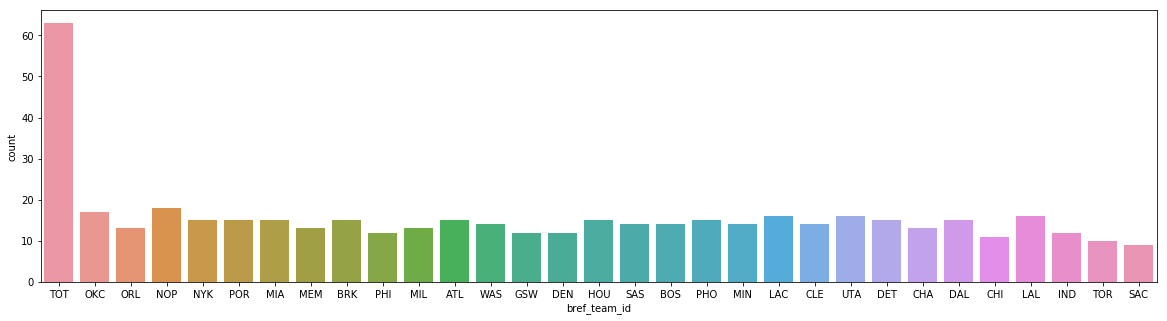

In [33]:
plt.figure(figsize = (20,5))
sns.countplot(x = nba_df['bref_team_id'], data = nba_df)

In [34]:
# There many players from the Team with Team ID == TOT. This might introduce a bias in training of the model. 
# Hence , it needs checking. TOT is used when a player has represented more than one team in a season.
# And the values associated with that player's row are the combined stats
# The value TOT is a valid value in this dataset
###### Refered: http://stats.nba.com/teams/ and https://www.reddit.com/r/nba/comments/7lt7qz/what_does_tot_mean_on_basketballreferencecom/

In [35]:
nba_df['pos'].unique()

array(['SF', 'C', 'PF', 'SG', 'PG', 'G', 'F'], dtype=object)

In [36]:
nba_df['pos'].nunique()

7

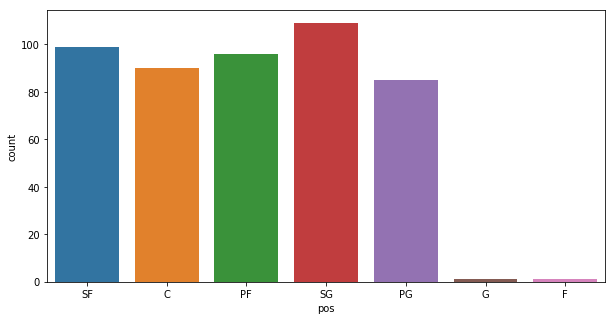

In [37]:
plt.figure(figsize = (10,5))
sns.countplot(x= nba_df['pos'], data = nba_df)

In [38]:
# Identify the players for whom these invalid values G and F
nba_df.loc[(nba_df['pos'].isin(['G','F'])),['player','pos']]

,player,pos
224,Damion James,G
356,Josh Powell,F


In [39]:
# Replace the invalid values with the ones mentioned above
nba_df['pos'].replace(to_replace ='G',value= 'SG',inplace=True)
nba_df['pos'].replace(to_replace ='F',value= 'PF',inplace=True)

In [40]:
# Check the players for whom these invalid values G and F
nba_df.loc[(nba_df['pos'].isin(['G','F'])),['player','pos']]

,player,pos


In [41]:
# Identify the players for whom these invalid values G and F
nba_df.loc[[224,356],['player','pos']]

,player,pos
224,Damion James,SG
356,Josh Powell,PF


In [42]:
# The replacement of the values was successful and the column is now clean.

In [43]:
# Getting Basic Statistical Information

In [44]:
nba_df.describe()

,age,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season_end
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.0
mean,26.509356,53.253638,25.571726,1237.386694,192.881497,424.463617,0.436268,39.613306,110.130977,0.288133,153.268191,314.332640,0.467357,0.480661,91.205821,120.642412,0.723842,55.810811,162.817048,218.627859,112.536383,39.280665,24.103950,71.862786,105.869023,516.582121,2013.0
std,4.198265,25.322711,29.658465,897.258840,171.832793,368.850833,0.098509,50.855639,132.751732,0.157492,147.223161,294.174554,0.104521,0.099388,103.667725,131.240639,0.158851,62.101191,145.348116,200.356507,131.019557,34.783590,30.875381,62.701690,71.213627,470.422228,0.0
min,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.0
25%,23.000000,32.000000,0.000000,388.000000,47.000000,110.000000,0.400000,0.000000,3.000000,0.238095,31.000000,67.000000,0.434783,0.451000,16.000000,22.000000,0.655000,12.000000,43.000000,55.000000,20.000000,9.000000,4.000000,21.000000,44.000000,115.000000,2013.0
50%,26.000000,61.000000,10.000000,1141.000000,146.000000,332.000000,0.437000,16.000000,48.000000,0.333333,110.000000,227.000000,0.474674,0.488000,53.000000,73.000000,0.754000,35.000000,135.000000,168.000000,65.000000,32.000000,14.000000,58.000000,104.000000,401.000000,2013.0
75%,29.000000,76.000000,54.000000,2016.000000,307.000000,672.000000,0.479000,68.000000,193.000000,0.375000,230.000000,459.000000,0.513932,0.525000,126.000000,179.000000,0.821000,73.000000,230.000000,310.000000,152.000000,60.000000,32.000000,108.000000,158.000000,821.000000,2013.0
max,39.000000,83.000000,82.000000,3122.000000,849.000000,1688.000000,1.000000,261.000000,615.000000,1.000000,706.000000,1408.000000,1.000000,1.000000,703.000000,805.000000,1.000000,440.000000,783.000000,1114.000000,721.000000,191.000000,219.000000,295.000000,273.000000,2593.000000,2013.0


In [45]:
# Exploring Data
# Uni-variate Numerical Columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000261508984A8>,
      dtype=object)

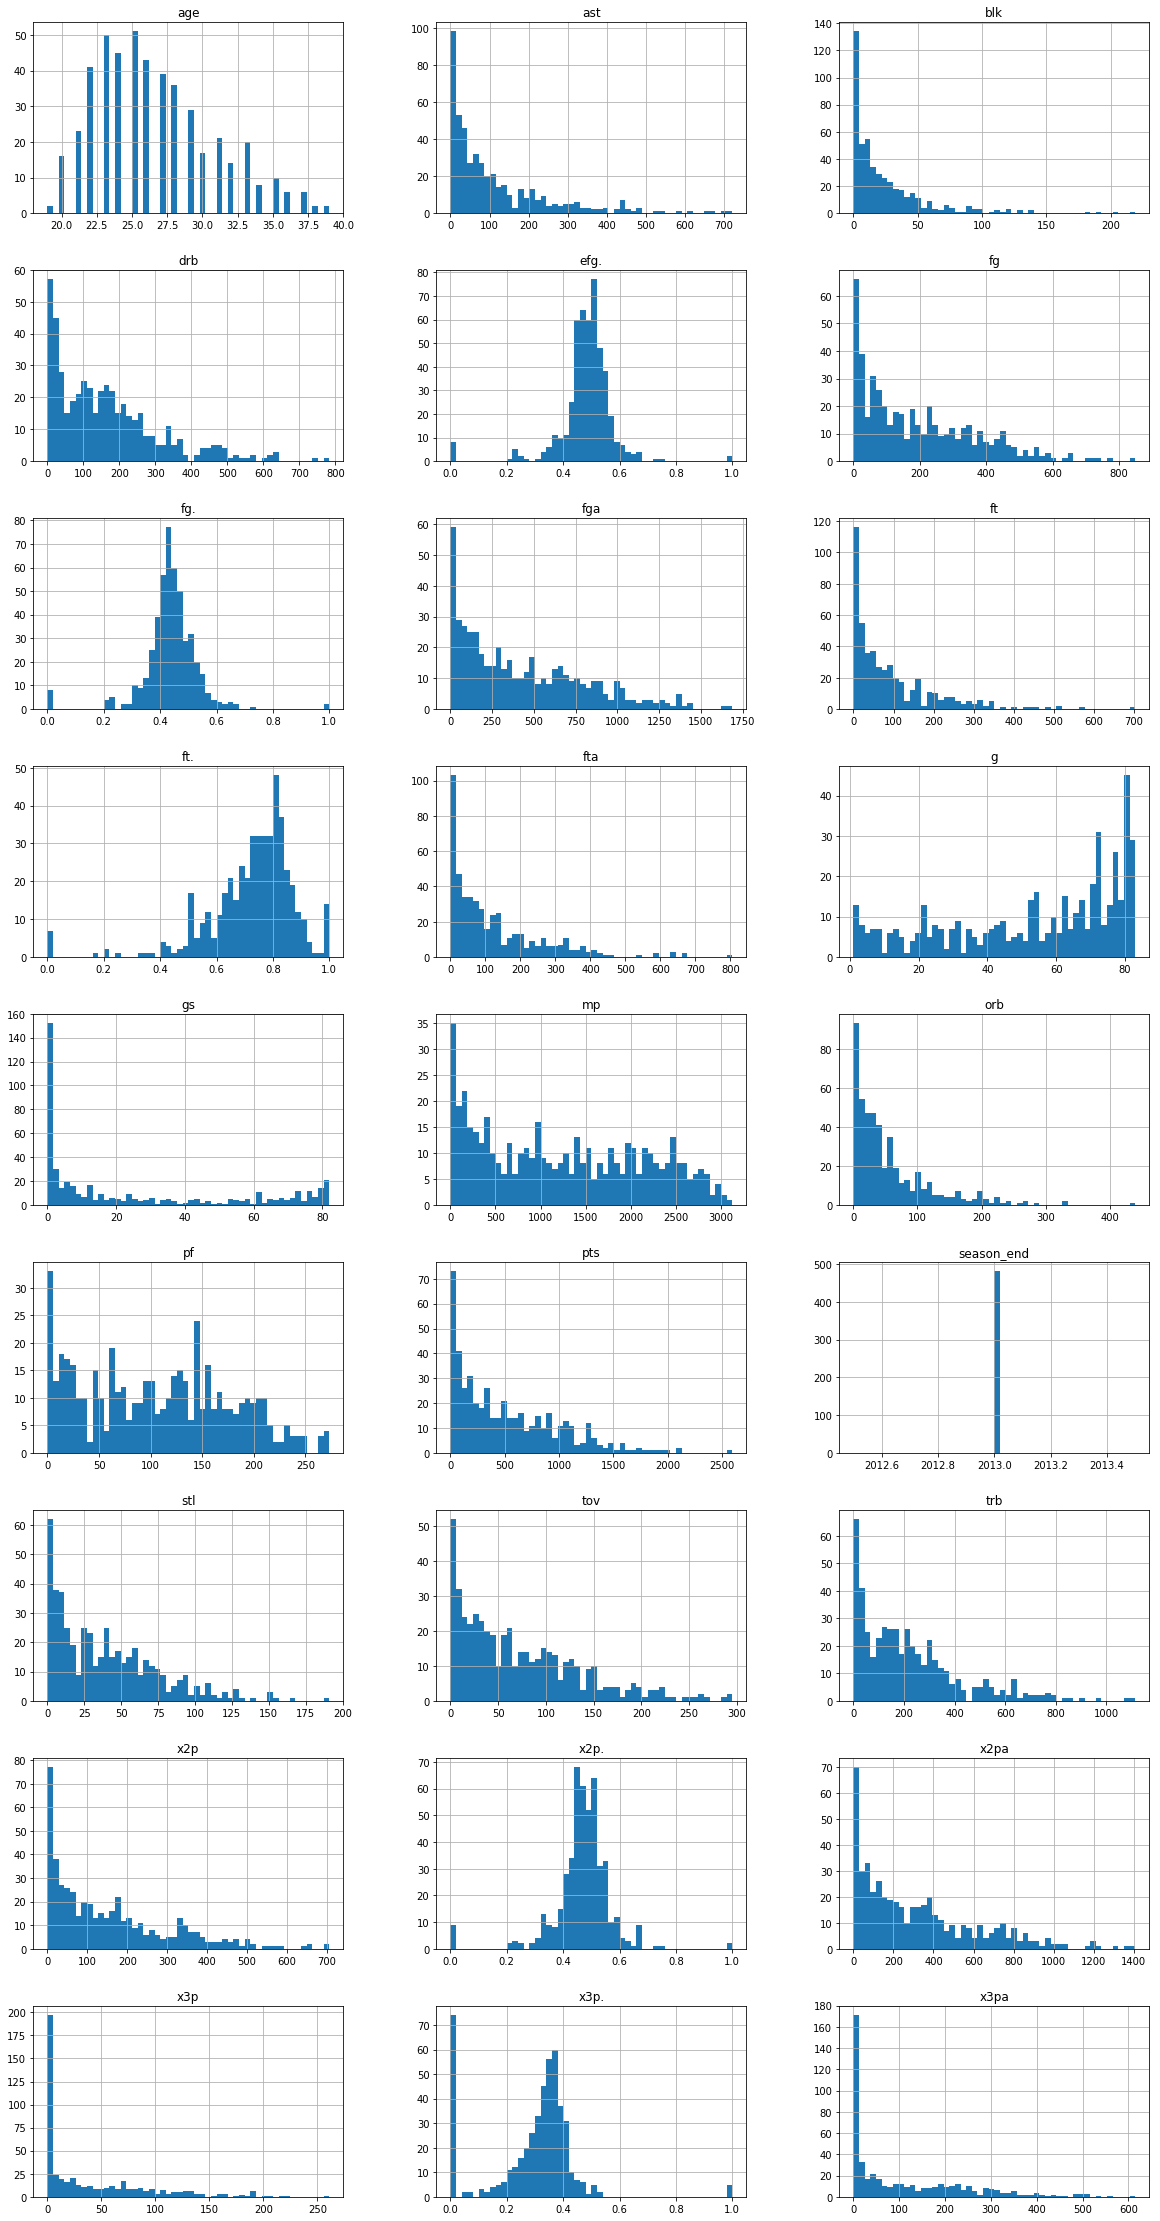

In [46]:
nba_df[num_cols].hist(bins=50,figsize=(20,40), layout= (9,3))

In [47]:
# majority of the columns have values which behave similar to exponential distribution 
# few with normally distributed behaviour 
# season_end columns has only one value repeated for every row

In [48]:
# Multi-variate

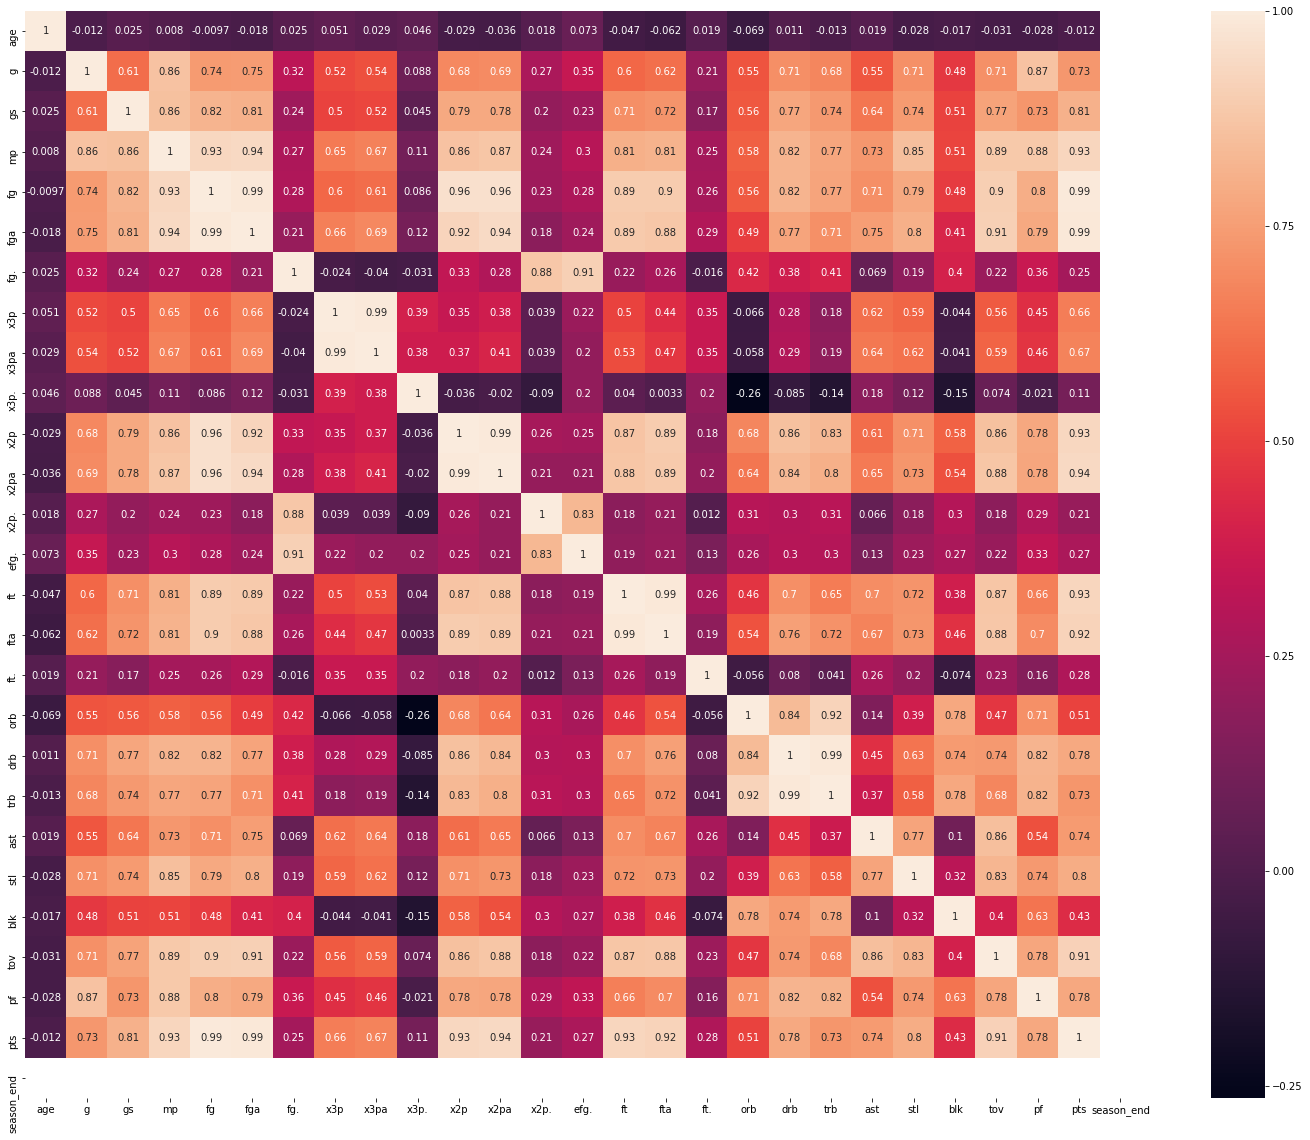

In [49]:
plt.figure(figsize=(25,20))
sns.heatmap(nba_df.corr(), annot = True)

In [50]:
print(nba_df.corr().iloc[-2:-1,:])

         age         g        gs        mp        fg       fga       fg.  \
pts -0.01191  0.728462  0.810294  0.927464  0.992041  0.989211  0.249419   

          x3p      x3pa      x3p.       x2p      x2pa      x2p.      efg.  \
pts  0.655342  0.672076  0.113962  0.931493  0.937036  0.213475  0.269157   

           ft       fta       ft.       orb       drb      trb       ast  \
pts  0.927618  0.918979  0.281958  0.505524  0.784675  0.72593  0.738295   

          stl       blk       tov       pf  pts  season_end  
pts  0.797449  0.433549  0.912724  0.77806  1.0         NaN  


The points scored by a player in the season 2013-14 is:

Strong correlation with
1.  g    -- Games played 
2.  gs   -- Games Started 
3.  mp   -- Minutes Played 
4.  fg   -- Field Goals 
5.  fga  -- Field Goal Attempts 
6.  x2p  -- 2-Point Field Goals 
7.  x2pa -- 2-point Field Goal Attempts 
8.  ft   -- Free Throws 
9.  fta  -- Free Throw Attempts 
10. drb  -- Defensive Rebounds 
11. trb  -- Total Rebounds 
12. ast  -- Assists 
13. stl  -- Steals 
14. tov  -- Turnovers 
15. pf   -- Personal Fouls

Moderate to strong correlation with
1. x3p  -- 3-Point Field Goals 
2. x3pa -- 3-Point Field Goal Attempts

In [51]:
# Encode Categorical Columns

In [52]:
cols_to_encode = ['pos','bref_team_id']
prefixes = ['pos','team']
nba_encoded= pd.get_dummies(data = nba_df, prefix = prefixes, columns = cols_to_encode, prefix_sep = '_', drop_first = True)

In [53]:
nba_encoded.columns

Index(['player', 'age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg.', 'x3p', 'x3pa',
       'x3p.', 'x2p', 'x2pa', 'x2p.', 'efg.', 'ft', 'fta', 'ft.', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'season', 'season_end',
       'pos_PF', 'pos_PG', 'pos_SF', 'pos_SG', 'team_BOS', 'team_BRK',
       'team_CHA', 'team_CHI', 'team_CLE', 'team_DAL', 'team_DEN', 'team_DET',
       'team_GSW', 'team_HOU', 'team_IND', 'team_LAC', 'team_LAL', 'team_MEM',
       'team_MIA', 'team_MIL', 'team_MIN', 'team_NOP', 'team_NYK', 'team_OKC',
       'team_ORL', 'team_PHI', 'team_PHO', 'team_POR', 'team_SAC', 'team_SAS',
       'team_TOR', 'team_TOT', 'team_UTA', 'team_WAS'],
      dtype='object')

In [54]:
nba_encoded.drop(['player','season','season_end'], axis = 1,inplace = True)

In [55]:
nba_encoded_cols = nba_encoded.columns.values
nba_encoded_cols

array(['age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg.', 'x3p', 'x3pa', 'x3p.',
       'x2p', 'x2pa', 'x2p.', 'efg.', 'ft', 'fta', 'ft.', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'pos_PF', 'pos_PG',
       'pos_SF', 'pos_SG', 'team_BOS', 'team_BRK', 'team_CHA', 'team_CHI',
       'team_CLE', 'team_DAL', 'team_DEN', 'team_DET', 'team_GSW',
       'team_HOU', 'team_IND', 'team_LAC', 'team_LAL', 'team_MEM',
       'team_MIA', 'team_MIL', 'team_MIN', 'team_NOP', 'team_NYK',
       'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR',
       'team_SAC', 'team_SAS', 'team_TOR', 'team_TOT', 'team_UTA',
       'team_WAS'], dtype=object)

In [56]:
# Data Preprocessing - Normalization with MinMaxScaler

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
nba_scaled_array = scaler.fit_transform(nba_encoded)

In [58]:
df_nba_scaled = pd.DataFrame(data = nba_scaled_array, columns = nba_encoded_cols)

In [59]:
df_nba_scaled.describe()

,age,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,pos_PF,pos_PG,pos_SF,pos_SG,team_BOS,team_BRK,team_CHA,team_CHI,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_TOR,team_TOT,team_UTA,team_WAS
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000
mean,0.375468,0.637239,0.311850,0.396151,0.227187,0.251459,0.436268,0.151775,0.179075,0.288133,0.217094,0.223248,0.467357,0.480661,0.129738,0.149866,0.723842,0.126843,0.207940,0.196255,0.156084,0.205658,0.110064,0.243603,0.387799,0.199222,0.201663,0.176715,0.205821,0.228690,0.029106,0.031185,0.027027,0.022869,0.029106,0.031185,0.024948,0.031185,0.024948,0.031185,0.024948,0.033264,0.033264,0.027027,0.031185,0.027027,0.029106,0.037422,0.031185,0.035343,0.027027,0.024948,0.031185,0.031185,0.018711,0.029106,0.020790,0.130977,0.033264,0.029106
std,0.209913,0.308814,0.361689,0.287491,0.202394,0.218514,0.098509,0.194849,0.215856,0.157492,0.208531,0.208931,0.104521,0.099388,0.147465,0.163032,0.158851,0.141139,0.185630,0.179853,0.181719,0.182113,0.140983,0.212548,0.260856,0.181420,0.401660,0.381825,0.404721,0.420427,0.168279,0.173998,0.162331,0.149642,0.168279,0.173998,0.156129,0.173998,0.156129,0.173998,0.156129,0.179512,0.179512,0.162331,0.173998,0.162331,0.168279,0.189991,0.173998,0.184838,0.162331,0.156129,0.173998,0.173998,0.135644,0.168279,0.142829,0.337727,0.179512,0.168279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.378049,0.000000,0.123999,0.055359,0.065166,0.400000,0.000000,0.004878,0.238095,0.043909,0.047585,0.434783,0.451000,0.022760,0.027329,0.655000,0.027273,0.054917,0.049372,0.027739,0.047120,0.018265,0.071186,0.161172,0.044350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.350000,0.731707,0.121951,0.365268,0.171967,0.196682,0.437000,0.061303,0.078049,0.333333,0.155807,0.161222,0.474674,0.488000,0.075391,0.090683,0.754000,0.079545,0.172414,0.150808,0.090153,0.167539,0.063927,0.196610,0.380952,0.154647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.914634,0.658537,0.645626,0.361602,0.398104,0.479000,0.260536,0.313821,0.375000,0.325779,0.325994,0.513932,0.525000,0.179232,0.222360,0.821000,0.165909,0.293742,0.278276,0.210818,0.314136,0.146119,0

In [60]:
# Generating Input data X and Output Y, and Split the Data for Training and Testing

In [61]:
X = df_nba_scaled.drop('pts', axis = 1)
Y = df_nba_scaled['pts']

In [62]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100)

In [63]:
# Fitting the KNN Models & Using Euclidean Distance as a distance metrics

In [64]:
k_values =[]
r_Square_train_values =[]
r_Square_test_values =[]
rmse_train_values = []
rmse_test_values =[]
accuracy_test =[]
accuracy_train =[]

import math

for k in range(1,21):
    knn = KNeighborsRegressor(n_neighbors = k, weights='uniform', algorithm='auto')
    model = knn.fit(x_train, y_train) 
    y_pred = model.predict(x_test)
    
    k_values.append(k)
    
    r_Square_train_values.append(metrics.r2_score(model.predict(x_train), y_train))
    r_Square_test_values.append(metrics.r2_score(model.predict(x_test), y_test))
    
    rmse_train_values.append(math.sqrt(metrics.mean_squared_error(model.predict(x_train), y_train)))
    rmse_test_values.append(math.sqrt(metrics.mean_squared_error(model.predict(x_test), y_test)))
    
    accuracy_train.append(model.score(x_train, y_train))
    accuracy_test.append(model.score(x_test, y_test))

    print("Accuracy: ", model.score(x_test, y_test),"for K-Value:",k)

Accuracy:  0.7513843147299952 for K-Value: 1
Accuracy:  0.8199725833331336 for K-Value: 2
Accuracy:  0.8580731090101001 for K-Value: 3
Accuracy:  0.886968662676202 for K-Value: 4
Accuracy:  0.8959555549179624 for K-Value: 5
Accuracy:  0.8992614554993184 for K-Value: 6
Accuracy:  0.9036493448407232 for K-Value: 7
Accuracy:  0.9072877074161129 for K-Value: 8
Accuracy:  0.9111726205321228 for K-Value: 9
Accuracy:  0.908236609041231 for K-Value: 10
Accuracy:  0.9072146074098933 for K-Value: 11
Accuracy:  0.9136840025075303 for K-Value: 12
Accuracy:  0.913021296223261 for K-Value: 13
Accuracy:  0.9059200749886736 for K-Value: 14
Accuracy:  0.9082728625112148 for K-Value: 15
Accuracy:  0.9074960092931297 for K-Value: 16
Accuracy:  0.9082081255476709 for K-Value: 17
Accuracy:  0.9038429793012481 for K-Value: 18
Accuracy:  0.9023496673490286 for K-Value: 19
Accuracy:  0.9014758950881321 for K-Value: 20


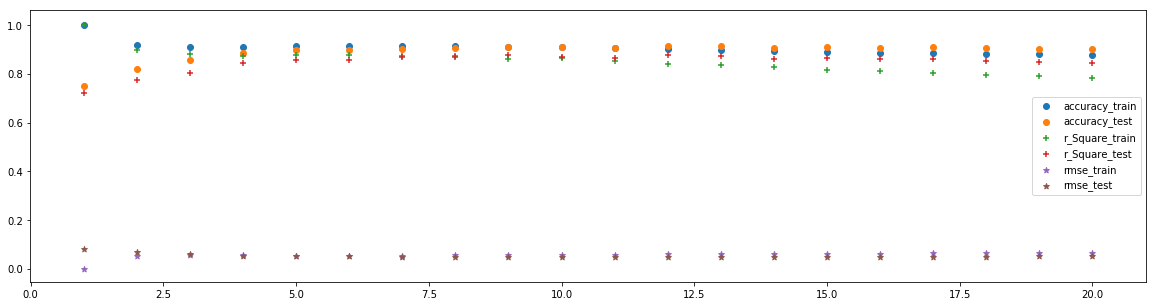

In [65]:
plt.figure(figsize = (20,5))

plt.scatter(k_values, accuracy_train, label = 'accuracy_train')
plt.scatter(k_values, accuracy_test, label = 'accuracy_test')

plt.scatter(k_values, r_Square_train_values, label = 'r_Square_train',marker='+')
plt.scatter(k_values, r_Square_test_values, label = 'r_Square_test',marker='+')

plt.scatter(k_values, rmse_train_values, label = 'rmse_train',marker='*')
plt.scatter(k_values, rmse_test_values, label = 'rmse_test',marker='*')

plt.legend()
plt.show()

In [66]:
# Feature selection

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 <a list of 59 Text xticklabel objects>)

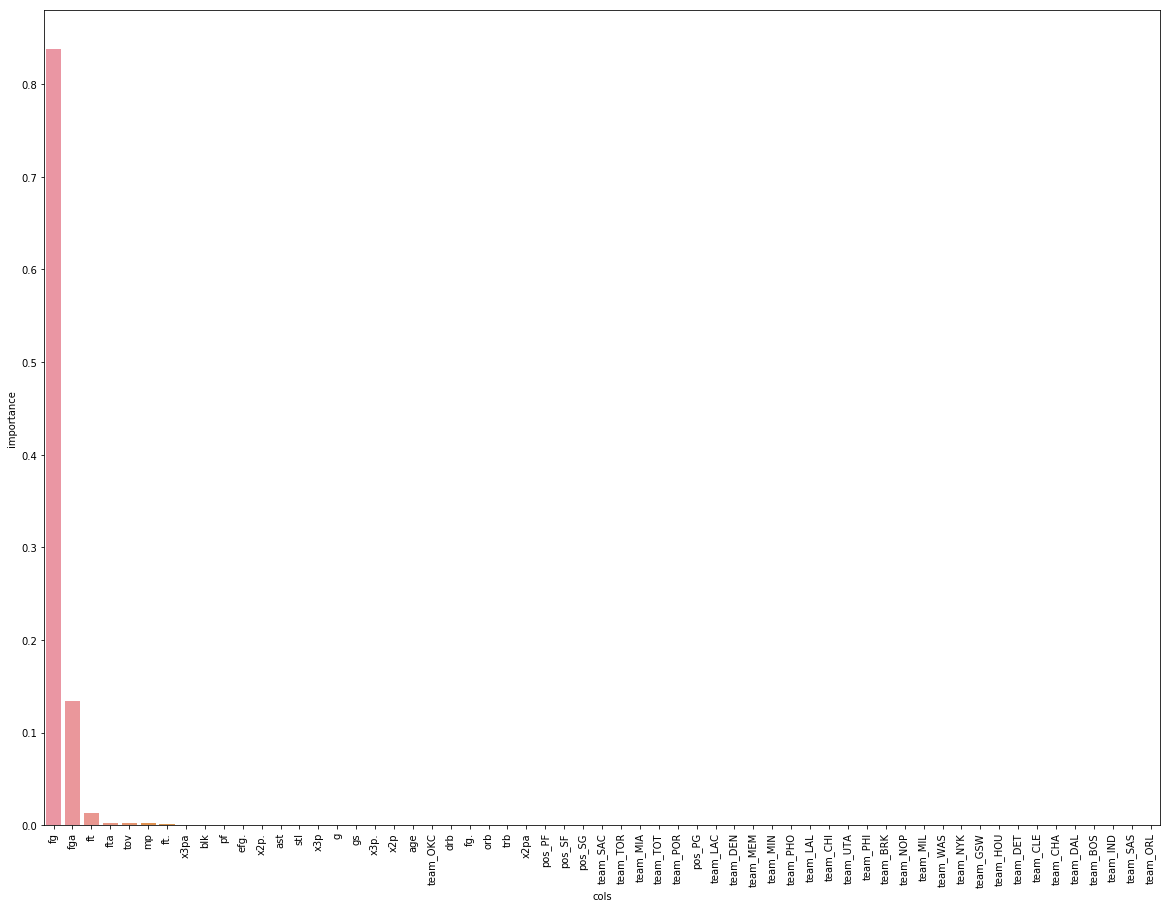

In [67]:
from sklearn.ensemble import RandomForestRegressor
rndf = RandomForestRegressor(n_estimators=150)
rndf.fit(x_train, y_train)
importance = pd.DataFrame.from_dict({'cols':x_train.columns, 'importance': rndf.feature_importances_})
importance = importance.sort_values(by='importance', ascending=False)
plt.figure(figsize=(20,15))
sns.barplot(importance.cols, importance.importance)
plt.xticks(rotation=90)

In [68]:
imp_cols = importance[importance.importance > 0.0005].cols.values
imp_cols

array(['fg', 'fga', 'ft', 'fta', 'tov', 'mp', 'ft.', 'x3pa'], dtype=object)

In [69]:
x1_train,x1_test, y1_train, y1_test = train_test_split(X[imp_cols],Y,test_size=0.2,random_state =100)

In [70]:
# Fit Features Selected Model and Collect the Metrics

In [71]:
k_values =[]
r2_train1_values =[]
r2_test1_values =[]
rmse_train1_values = []
rmse_test1_values =[]
accuracy_test1 =[]
accuracy_train1 =[]
rmse_val = [] #to store rmse values for different k

import math

for k in range(1,21):
    knn = KNeighborsRegressor(n_neighbors = k, weights='uniform', algorithm='auto')
    model = knn.fit(x1_train, y1_train) 
    y_pred1 = model.predict(x1_test)
    error = sqrt(mean_squared_error(y1_test,y_pred1)) #calculate rmse
    rmse_val.append(error) #store rmse values

    print("Accuracy: %.5f" % model.score(x1_test, y1_test) , "& RMSE value: %.5f" % error ," for K-Value: %.0f" % k)

Accuracy: 0.96567 & RMSE value: 0.02994  for K-Value: 1
Accuracy: 0.97766 & RMSE value: 0.02415  for K-Value: 2
Accuracy: 0.98287 & RMSE value: 0.02115  for K-Value: 3
Accuracy: 0.98006 & RMSE value: 0.02282  for K-Value: 4
Accuracy: 0.98555 & RMSE value: 0.01942  for K-Value: 5
Accuracy: 0.98595 & RMSE value: 0.01915  for K-Value: 6
Accuracy: 0.98653 & RMSE value: 0.01876  for K-Value: 7
Accuracy: 0.98644 & RMSE value: 0.01882  for K-Value: 8
Accuracy: 0.98570 & RMSE value: 0.01932  for K-Value: 9
Accuracy: 0.98453 & RMSE value: 0.02010  for K-Value: 10
Accuracy: 0.98341 & RMSE value: 0.02081  for K-Value: 11
Accuracy: 0.98274 & RMSE value: 0.02123  for K-Value: 12
Accuracy: 0.98296 & RMSE value: 0.02109  for K-Value: 13
Accuracy: 0.98295 & RMSE value: 0.02110  for K-Value: 14
Accuracy: 0.98279 & RMSE value: 0.02120  for K-Value: 15
Accuracy: 0.98235 & RMSE value: 0.02147  for K-Value: 16
Accuracy: 0.98293 & RMSE value: 0.02111  for K-Value: 17
Accuracy: 0.98436 & RMSE value: 0.02021 

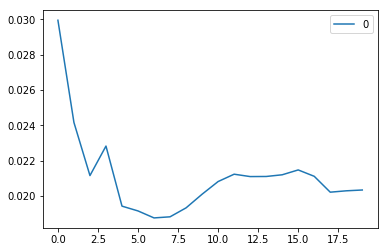

In [72]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [73]:
# The optimal value of k in the given situation
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(x1_train, y1_train)
model.best_params_

{'n_neighbors': 4}

In [74]:
knn_f = KNeighborsRegressor(n_neighbors = 4, weights='uniform', algorithm='auto')
model_f = knn_f.fit(x1_train, y1_train) 
print('K = 4')
print('-'*40)
print('Accuracy : ', model_f.score(x1_test, y1_test))
print('R2-score : ', metrics.r2_score(model_f.predict(x1_test), y1_test))
print('RMSE     : ', math.sqrt(metrics.mean_squared_error(model_f.predict(x1_test), y1_test)))

K = 4
----------------------------------------
Accuracy :  0.9800563852807587
R2-score :  0.97840391051001
RMSE     :  0.022820256034845412


Choosing the model for deployment
Therefore the model we choose to deploy should have:

1. k = 4,
2. test size = 0.2 or 20% of dataset and random_state = 100
3. training features = [ 'fg', 'fga', 'ft', 'fta', 'tov', 'mp', 'ft.', 'x3pa']
4. Distance Metric = Euclidean Distance